## Multi-agent Reinforcement Learning in Auctions

### Abstract

The project aims to use Multi-Agent Reinforcement Learning (MARL) to train agents to play in different auction environments in a decentralised manner, and to show when convergence to a Nash equilibrium (NE) occurs. We will implement both an ascending auction (called an English auction) and a descending auction (called a Dutch auction), and we will test both policy gradient methods and Q-Learning methods. 

### Introduction

This work applies reinforcement learning methods to auction environments, in which many players are competing to obtain an item for which they have a private valuation. As auctions underpin many functions of the modern economic system, it is important to analyse how decentralised multi-agent reinforcement learning performs in these environments, especially as reinforcement learning is becoming more widely utilised. There is an extensive literature on auctions from a game theoretic perspective. Klemperer (2004) provides a comprehensive analysis of the standard results, which have been much celebrated, especially with Paul Milgrom and Robert Wilson winning the 2020 Nobel Prize in Economics for their work in auctions. 

Kanmaz and Surer (2020) use Q-Learning in their approach to (MARL) for auction environements, and showed that agents' policies converged to a Nash equilibrium in a sealed bid auction or a sequential open bid auction. Unlike the environments that we will present in this work, these types of auctions do not have multiple rounds of bidding, and hence are strategically simplier. When they considered the two player second price auction with multiple rounds of bidding, the players' policies did form a Nash equilibrium, however this Nash equilibrium is not the natural subgame perfect Nash equilibrium in which every player bids their true valuation. Instead, this equilibrium involves the non-credible threat of one player bidding the maximum allowed price and the other player dropping out of the auction immediately. The work that we will present will show that the natural Nash equilibrium can be obtained, as well as apply different learning algorithms to larger and more challenging environemnts.

There has been growing interest into convergence guarentees of MARL algorithms. The first paper on this topic was Littman (1992), which developed Minimax-Q for zero-sum games, which was then built upon by Hu and Wellman (2003) for Nash Q-Learning. However, as argued in Shoham, Powers and Grenager (2003), these constructions are quite artifical, as they require the computation of a minimax strategy or a Nash equilibrium using the Q-table in order to update the strategy. It would be more natural to consider environments in which the learning dynamics from single agent reinforcement learning converge to a Nash equilibrium. Leonardos, et al. (2021) approached the problem from this direction and showed that policy gradient methods converge to a Nash equilibrium in Markov potential games. Importantly for auctions, Daskalakis, Foster and Golowich (2022) showed that in competitive environments, such as two player auction, policy gradient methods would converge to a Nash equilibrium. They used a two-timescale rule, which meant that one player would update their policy a lot slower than the other. While this is an impressive result, it is limited to only two player games, whereas the work that we are presenting wishes to investigate auctions with more players. Giannou, et al. (2022) proves that policy-gradient methods will converge to a strict NE if the original policy profile starts near enough to this equilibrium. 

While this project does not add to the theoretic framework, it presents an interesting example of convergence to NE from the dynamics of MARL, and points to futher assumptions about the environments for these models that may ensure convergence.


### Models

We will consider when there is a single item to be sold at auction. Let $N = \{1,...,n \}$ be the set of agents and $v_{i} \in \mathbb{R}$ be agent $i$'s valuation of the item. We will assume that these valuation are independent and private. This means that they are drawn independently from a distribution, and the other players can only condition their policy on their own valuation and the current price of the auction. 

We will investigate two different types of auctions. The first type is the ascending auction, which is often called an English auction. The way that we will choose to model this auction is by having the price start at zero and, over several rounds, the price will increase by one. In each round, each player will simultaneously choose to stay in or withdraw from the auction. If a player chooses to stay in the auction, they can carry on bidding in the following rounds, otherwise they cannot. There are three ways that this auction can end. If there is only player remaining in the auction, then they win the auction. Their reward will be their private valuation of the item minus the price at which the second to last player withdrew from the auction. The second way the auction can end is if the auction reaches the highest price allowed and there is more than one player still in the auction. In this case, the winner is chosen uniformly at random from the remaining players, and the winner's reward will be their private valuation of the item minus the current price of the auction. The final way that the auction can end is if all remaining players from a round drop out of the auction. In this case, the winner and their reward is chosen in the same way as in the previous case. Those players that do not win the auction get a reward of zero. 

The second type of auction that we will investigate is the descending auction, which is often called the Dutch auction. We will model this auction by having a fixed starting price and, over several rounds, reduce the price by one. As before, in each round, the players will simultaneously choose to stay in or withdraw from the auction. In the descending auction, the first player who withdraws from the auction wins the auction. There are therefore three ways for the auction to end. The first way is that one player withdraws from the auction in a certain round. If this occurs, they win the auction and pay the price of the round. The second way is that several players withdraw from the auction in a certain round. The winner of the auction is then decided uniformly at random from the players that withdrew. Again, they pay the price at that round. The final way is if no one withdraws from the auction. In this case, we will have that no one wins the auction and no one gets any reward. 

From the mechanism designer's perspective, the environment is a sequence of states, where each state $s$ is given by the players' valuations $(v_1,...,v_n)$ and a price $p$. From the players' perspective, player $i$ has a partial observation of the state $s_i = (v_i, p)$ upon which they condition their action. 


### Nash Equilibrium

In most Reinforcement Learning environments, the benchmark that one sets is to obtain a high reward for the agent. In MARL, this is not the correct benchmark because one needs to consider that the agents' interests may not be aligned. Instead, we will use the benchmark of a Nash equilibrium, which, informally, is a strategy profile such that no player has a strictly profitable deviation from their strategy.

In the appendix, we will formally define a Nash equilibrium, and show that, if one assumes that the agents' private valuations are independently and identically distributed over an interval, then there is a unique differentiable strictly-increasing Nash equilibrium for both environments. This Nash equilibrium is of the form of a threshold strategy, which are strategies which specify a price that an agent is willing to bid for the object if and only if the price is less than this threshold.

Specifically, one obtains that for the English auction the policy profile that has agent $i$ using their private valuation $v_i$ as their threshold forms a Nash Equilibrium, and, for the Dutch auction, the threshold for player $i$ is $\frac{n-1}{n} v_i$. However, there is an assumption in this that the price is continuous, whereas in our model of the English and Dutch auctions, the price changes in discrete amounts. Hence, these strategy profiles will be approximations for Nash equilibria in our model.

### Implementation

We first need to import some standard libraries that we will use, and define the function that will be used to plot the policy of the policy-gradient agents. 

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


In [3]:
def three_dimensional_plot(player, policy_table, max_valuation, price_increment):
    figure = plt.figure(figsize=(12, 8))
    axis = figure.add_subplot(projection='3d')
    axis.set_title(f"Policy of player {player + 1}")
    axis.set_xlabel(f"Valuation of player {player + 1}")
    axis.set_ylabel("Price")
    axis.set_zlabel("Probability of remaining in the auction")
    x = np.array(range(max_valuation + 1))
    y = np.array(range(0, max_valuation + price_increment + 1, price_increment))
    X, Y = np.meshgrid(x, y)
    axis.plot_surface(X, Y, policy_table, cmap=plt.cm.coolwarm, linewidth=0, rstride=1, cstride=1)
    plt.show()

Below are the four environments that we will use to model the auctions. For both the ascending and descending auctions, there are two environments. One of these two environments is compatible with deep reinforcement learning, and the other is not.

### Ascending Auction for MARL

In [4]:
class RisingAuctionEnv():

    def __init__(self, n_agents, max_valuation, price_increment, start_price = 0):
        self.n_agents = n_agents
        self.max_valuation = max_valuation
        self.price_increment = price_increment
        self.max_price = max_valuation + price_increment
        self.start_price = start_price
        self.number_stages = int(self.max_price / self.price_increment) + 1
        self.withdraw = 0
        self.remain = 1
        
        self.reset()

    def reset(self):
        self.current_price = self.start_price
        self.valuations = np.random.randint(0, self.max_valuation + 1, size=self.n_agents)
        self.rewards = [0] * self.n_agents 
        self.remaining_players = [self.remain] * self.n_agents # 1 if remaining 
        return self.current_price, self.valuations
    
    
    def step(self, actions):

        new_remaining_players = [self.withdraw] * self.n_agents
        
        for player, participation in enumerate(self.remaining_players):
            
            # Make sure all players that have already withdrawn cannot bid further:
            if participation == self.withdraw:
                actions[player] = self.withdraw
            
            # Establish which players are remaining in the next round
            elif actions[player] == self.remain:
                new_remaining_players[player] = self.remain
        

        # If there is more than one player remaining and max price is not reached, then the auction
        # is not finished. 
        if np.sum(new_remaining_players) > 1 and self.current_price < self.max_price:
            done = False
            winner = None
            self.current_price += self.price_increment
        
        # If there is still more than one player bidding at the max price, then we choose randomly from 
        # these players.
        elif np.sum(new_remaining_players) > 1:
            done = True
            winner = np.random.choice([player for player, action in enumerate(actions) if action == self.remain])
            self.rewards[winner] = self.valuations[winner] - self.current_price
        
        # If there is only one player left, then they are the winner.
        elif np.sum(new_remaining_players) == 1:
            done = True
            winner = np.argmax(actions)
            self.rewards[winner] = self.valuations[winner] - (self.current_price - self.price_increment) 

        # If all players drop out, then the winner is chosen randomly from the players of the previous round.
        else:
            done = True
            winner = np.random.choice([player for player, participation in enumerate(self.remaining_players) if participation == self.remain])
            self.rewards[winner] = self.valuations[winner] - self.current_price 
        
        self.remaining_players = new_remaining_players

        return self.current_price, self.rewards, winner, done

### Ascending Auction for Deep MARL

In [5]:
class RisingAuctionDeepEnv():

    def __init__(self, n_agents, max_valuation, price_increment, start_price = 0):
        self.n_agents = n_agents
        self.max_valuation = max_valuation
        self.price_increment = price_increment
        self.max_price = max_valuation + price_increment
        self.start_price = start_price
        self.number_stages = int(self.max_price / self.price_increment) + 1
        self.withdraw = 0
        self.remain = 1
        
        self.reset()

    def reset(self):
        self.current_price = self.start_price
        self.valuations = torch.randint(0, self.max_valuation + 1, (self.n_agents,))
        self.rewards = [0] * self.n_agents
        self.remaining_players = [self.remain] * self.n_agents # 1 if remaining 
        return torch.concatenate((torch.tensor([self.current_price]), self.valuations))
    
    
    def step(self, actions):

        new_remaining_players = [self.withdraw] * self.n_agents
        
        for player, participation in enumerate(self.remaining_players):
            
            # Make sure all players that have already withdrawn cannot bid further:
            if participation == self.withdraw:
                actions[player] = self.withdraw
            
            # Establish which players are remaining in the next round
            elif actions[player] == self.remain:
                new_remaining_players[player] = self.remain
        

        # If there is more than one player remaining and max price is not reached, then the auction
        # is not finished. 
        if np.sum(new_remaining_players) > 1 and self.current_price < self.max_price:
            done = False
            winner = None
            self.current_price += self.price_increment
        
        # If there is still more than one player bidding at the max price, then we choose randomly from 
        # these players.
        elif np.sum(new_remaining_players) > 1:
            done = True
            winner = np.random.choice([player for player, action in enumerate(actions) if action == self.remain])
            self.rewards[winner] = self.valuations[winner] - self.current_price
        
        # If there is only one player left, then they are the winner.
        elif np.sum(new_remaining_players) == 1:
            done = True
            winner = np.argmax(actions)
            self.rewards[winner] = self.valuations[winner] - (self.current_price - self.price_increment)

        # If all players drop out, then the winner is chosen randomly from the players of the previous round.
        else:
            done = True
            winner = np.random.choice([player for player, participation in enumerate(self.remaining_players) if participation == self.remain])
            self.rewards[winner] = self.valuations[winner] - self.current_price
        
        self.remaining_players = new_remaining_players

        return torch.concatenate((torch.tensor([self.current_price]), torch.tensor(self.rewards))), winner, done

### Descending Auction for MARL

In [6]:
class FallingAuctionEnv():
    
    def __init__(self, n_agents, max_valuation, price_increment, min_price = 0):
        self.n_agents = n_agents
        self.max_valuation = max_valuation
        self.min_price = min_price 
        self.price_increment = price_increment
        self.start_price = self.max_valuation + self.price_increment
        self.number_stages = int(self.start_price / self.price_increment) + 1
        self.rewards = [0] * n_agents 
        self.withdraw = 0
        self.remain = 1

        
        self.reset()

    def reset(self):
        self.current_price = self.start_price
        self.valuations = np.random.randint(0, self.max_valuation + 1, size=self.n_agents)
        self.rewards = [0] * self.n_agents 
        return self.current_price, self.valuations

    def step(self, actions):
        # here actions is a list so that all actions of all players are passed simultaneously 
        if np.isin(self.withdraw, actions): 
            # multiple winners chosen randomly 
            winner = np.random.choice([player for player, action in enumerate(actions) if action == self.withdraw])
            self.rewards[winner] = self.valuations[winner] - self.current_price
            done = True

        else:
            done = False
            winner = None
            # increment price (only when no ones wins)
            self.current_price -= self.price_increment
        
        if self.current_price < self.min_price:
            done = True

        return self.current_price, self.rewards, winner, done

### Descending Auction for Deep MARL

In [7]:
class FallingAuctionDeepEnv():
    
    def __init__(self, n_agents, max_valuation, price_increment, min_price = 0):
        self.n_agents = n_agents
        self.max_valuation = max_valuation
        self.min_price = min_price 
        self.price_increment = price_increment
        self.start_price = self.max_valuation + self.price_increment
        self.number_stages = int(self.start_price / self.price_increment) + 1
        self.rewards = [0] * n_agents 
        self.withdraw = 0
        self.remain = 1
        
        self.reset()

    def reset(self):
        self.current_price = self.start_price
        self.valuations = torch.randint(0, self.max_valuation + 1, (self.n_agents,))
        self.rewards = [0] * self.n_agents
        return torch.concatenate((torch.tensor([self.current_price]), self.valuations))

    def step(self, actions):
        # here actions is a list so that all actions of all players are passed simultaneously 
        if np.isin(self.withdraw, actions): 
            # multiple winners chosen randomly 
            winner = np.random.choice([player for player, action in enumerate(actions) if action == self.withdraw])
            self.rewards[winner] = self.valuations[winner] - self.current_price
            done = True

        else:
            done = False
            winner = None
            # increment price (only when no ones wins)
            self.current_price -= self.price_increment
        
        if self.current_price < self.min_price:
            done = True

        return torch.concatenate((torch.tensor([self.current_price]), torch.tensor(self.rewards))), winner, done

### Neural Network

Below we describe the neural network architecture that we will use for the deep policy gradient method.

In [8]:
class NeuralNetwork():

    save_path_format='./NeuralNetworks/{name}.pt'

    def __init__(self, learning_rate, number_inputs):
    
        self.learning_rate =learning_rate
        self.number_inputs = number_inputs

    def reset(self):
        self.policy = torch.nn.Sequential(
                            nn.Linear(self.number_inputs, 200), 
                            nn.ReLU(),
                            nn.Linear(200,200),
                            nn.ReLU(),
                            nn.Linear(200,2),
                            nn.Softmax(dim=0))                    
        self.optimiser = torch.optim.Adam(self.policy.parameters(), lr=self.learning_rate)
        
        return self.policy, self.optimiser

    def save(self, network_name): 
        return torch.save(self.policy.state_dict(),self.save_path_format.format(name = network_name))

    def load(self, network_name):
        self.policy=torch.load(self.save_path_format.format(name = network_name))

    def define(self, policy, optimiser):
        self.policy = policy
        self.optimiser = optimiser     

### Policy Gradient Methods

Policy gradient methods are a type of reinforcement learning algorithm that aims to learn the optimal policy of an agent by computing an estimate for the gradient of the player's payoff with respect to the parameters of the policy, and then updating the player's policy by taking a step in the direction of this gradient. 

For each agent $i \in N$, we will model their policy given their observation $s_i$ of state $s$ by having the probability of bidding given by:

$$ \pi_{i}(s_{i}; \theta^{s_{i}}_i) = \frac{\exp(\theta^{s_{i}}_i)}{1+\exp(\theta^{s_{i}}_i)} $$ 

Note that this probability is always within the interior of the interval $[0,1]$. The standard procedure here is to take gradient of the natural logorithm as an estimator of the gradient, as the logorithm is an increasing function. 

$$
\nabla_{\theta^{s_{i}}_{i}} \log(\pi_{i}(s_{i}; \theta^{s_{i}}_i)) 
 = \nabla_{\theta^{s_{i}}_{i}}(\theta^{s_{i}}_i - \log(1+\exp(\theta^{s_{i}}_i)))
 = 1 - \frac{\exp(\theta^{s_{i}}_i)}{1+\exp(\theta^{s_{i}}_i)}
 = \frac{1}{1+\exp(\theta^{s_{i}}_i)}
$$

$$
\nabla_{\theta^{s_{i}}_{i}} \log(1 - \pi_{i}(s_{i}; \theta^{s_{i}}_i)) 
 = \nabla_{\theta^{s_{i}}_{i}}(- \log(1+\exp(\theta^{s_{i}}_i)))
 = - \frac{\exp(\theta^{s_{i}}_i)}{1+\exp(\theta^{s_{i}}_i)}
 = - \frac{1}{1+\exp(- \theta^{s_{i}}_i)}
$$

Suppose the action taken by player $i$ was to bid and they received reward $r_i$. Then, their new probability of bidding given $s_i$ is parameterised by:

$$ (\theta^{s_{i}}_i)^{\text{new}} =  \theta^{s_{i}}_i + \gamma \times r_i \times \frac{1}{1+\exp(\theta^{s_{i}}_i)} $$ 

for some step size $\gamma > 0$. Note that, if the reward is positive, then the probability increases.

Similarly, suppose the action taken by player $i$ was to withdraw and they received reward $r_i$. Then, their new probability of bidding given $s_i$ is parameterised by:

$$ (\theta^{s_{i}}_i)^{\text{new}} = \theta^{s_{i}}_i - \gamma \times r_i \times \frac{1}{1+\exp( - \theta^{s_{i}}_i)} $$ 

Now, one can note that, if the reward is positive, then the probability decreases. 

By the Policy Gradient Theorem, in a stationary environment, these dynamics should converge to the optimal policy if the step size is small enough. However, convergence guarentees in MARL are weaker because the dynamics of having all the agents update their strategies means that the environment is non-stationary. 

In [9]:
class PolicyGradientAlgorithm():

    def __init__(self, environment, number_episodes, learning_rate, credit_factor):
        
        self.environment = environment
        self.number_episodes = number_episodes
        self.learning_rate = learning_rate
        self.credit_factor = credit_factor
        self.number_stages = self.environment.number_stages
        self.number_players = self.environment.n_agents
        self.max_valuation = self.environment.max_valuation
        self.policies = np.zeros((self.number_players, self.number_stages, self.max_valuation + 1)) 
        # Policy is given as a singular number: prob of playing 1

        self.reset()

    
    def reset(self):
        for player in range(self.number_players):
            self.policies[player] = np.zeros((self.number_stages, self.max_valuation + 1))

    def reinforce_algorithm(self, player, valuation, number_episodes):
        for _ in range(number_episodes):
            current_price, valuations= self.environment.reset()
            self.environment.valuations[player] = valuation
            episode_memory = list()
            payoff = 0
            done = False
            while not done:
                actions = [self.sample_policy(player_, current_price, valuations[player_]) for player_ in range(self.number_players)]
                actions[player] = np.random.binomial(1, 0.5)    
                episode_memory.append([current_price, actions[player]])
                current_price, rewards, _, done = self.environment.step(actions)
                # If the player being trained withdraws without winning, then the environment stops early. 
                if actions[player] == self.environment.withdraw:
                    done = True
                payoff += rewards[player]
            for episode in episode_memory:
                price, action = episode
                parameter = self.policies[player, price, valuation]
                if action == 1:
                    self.policies[player, price, valuation] += self.learning_rate * payoff * (1/(1+np.exp(parameter)))
                else:
                    self.policies[player, price, valuation] -= self.learning_rate * payoff * (1/(1+np.exp(-parameter)))

    
    def sample_policy(self, player, price, valuation):
        parameter = self.policies[player, price, valuation]
        random_number = np.random.random()
        if random_number < 1/(1+np.exp(-parameter)):
            return 1
        else:
            return 0

    """
    Implements an asynchronous policy gradient method for the falling auction environment. 
    """
    def policy_gradient(self, number_episodes):
        np.random.seed(10)
        for _ in range(self.number_episodes):
            for player in range(self.number_players):
                for valuation in range(self.max_valuation + 1):
                    self.reinforce_algorithm(player, valuation, number_episodes)
    
    def show_policy(self, player):
        policy = np.zeros((self.number_stages, self.max_valuation + 1))
        for price in range(self.number_stages):
            for valuation in range(self.max_valuation + 1):
                parameter = self.policies[player, price, valuation]
                policy[price, valuation] = 1/(1+np.exp(-parameter))
        return policy

In [10]:
class DeepReinforceAlgorithm():

    def __init__(self, environment, neural_network, episodes_per_batch, number_batches):

        self.episodes_per_batch = episodes_per_batch    
        self.environment = environment
        self.number_players = self.environment.n_agents
        self.number_stages = self.environment.number_stages
        self.number_batches = number_batches
        self.policies = list()
        self.optimisers = list() 
        self.neural_network = neural_network

        self.reset_policies_optimisers()


    # Initialises policies and optimisers
    def reset_policies_optimisers(self):

        for _ in range(self.number_players):
            policy, optimiser = self.neural_network.reset()
            self.policies.append(policy)
            self.optimisers.append(optimiser)

    # Samples a policy of a player given the state
    def sample_policy(self, player, current_price, valuation):
            probability = self.policies[player](torch.tensor([float(current_price), float(valuation)]))
            action = np.random.choice(np.array([0,1]), p = probability.data.numpy())
            return action  
    
    # Runs an episodes of the auction and returns the states, actions and future rewards of a player.
    def run_episode(self, player):
        state = self.environment.reset()
        current_price = state[0]
        valuations = state[1:]
        episode_memory = list()
        done = False
        while not done:
            actions = [self.sample_policy(player_, current_price, valuations[player_]) for player_ in range(self.number_players)] 
            previous_state = torch.tensor([float(current_price), float(valuations[player])])
            state, _, done = self.environment.step(actions)
            current_price = state[0]
            rewards = state[1:]
            # If the player being trained withdraws without winning, then the environment stops early. 
            if actions[player] == self.environment.withdraw:
                done = True
            episode_memory.append([previous_state, actions[player], rewards[player]])
        states = torch.stack([item[0] for item in episode_memory])
        actions = torch.tensor([item[1] for item in episode_memory])
        rewards = torch.tensor([item[2] for item in episode_memory])
        future_rewards = self.future_rewards(rewards)
        return states, actions, future_rewards
    

    # Method that performs the Reinforce algorithm.
    def reinforce(self):

        for _ in range(self.number_batches):
            for player in range(self.number_players):
                episode_results = [self.run_episode(player) for _ in range(self.episodes_per_batch)]
                states = torch.cat([result[0] for result in episode_results],0)
                actions = torch.cat([result[1] for result in episode_results],0)
                rewards = torch.cat([result[2] for result in episode_results],0)

                probabilities = torch.stack([self.policies[player](state) for state in states])
                action_probabilities = probabilities.gather(dim = 1, index = actions.long().view(-1,1)).squeeze()
                loss = - torch.sum(rewards * torch.log(action_probabilities))
                
                self.optimisers[player].zero_grad()
                loss.backward()
                self.optimisers[player].step()

    # Calculates the future rewards without credit assignment discounting.
    def future_rewards(self,rewards):
        rewards = torch.flip(rewards, [0])
        rewards = torch.cumsum(rewards, 0)
        rewards = torch.flip(rewards, [0])
        return rewards
    
    # Returns a table that indicates the probability of playing "Remain" for each state.
    def policy_table(self, player):
        table = np.zeros((self.number_stages, self.environment.max_valuation + 1))
        for price in range(self.number_stages):
            for valuation in range(self.environment.max_valuation + 1):
                table[price][valuation] = self.policies[player](torch.tensor([float(price), float(valuation)]))[1]
        return table
    
    def save_networks(self):
        neural_network = NeuralNetwork(0.001, 2)
        _, _ = neural_network.reset()
        for player in range(self.number_players):
            neural_network.define(self.policies[player], self.optimisers[player])
            neural_network.save(f"Player {player + 1} of {self.number_players} with maximum valuation {self.environment.max_valuation}" )

### Policy Gradient Methods with Ascending Auctions

Let us first look at a small example:

In [11]:
number_of_players = 2
max_valuation = 4
price_increment = 1
number_episodes = 5_000
learning_rate = 0.001
credit_factor = 1
price_increment = 1

In [21]:
auction = RisingAuctionEnv(number_of_players, max_valuation, price_increment)
policy_gradient = PolicyGradientAlgorithm(auction, number_episodes, learning_rate, credit_factor)
policy_gradient.policy_gradient(100)

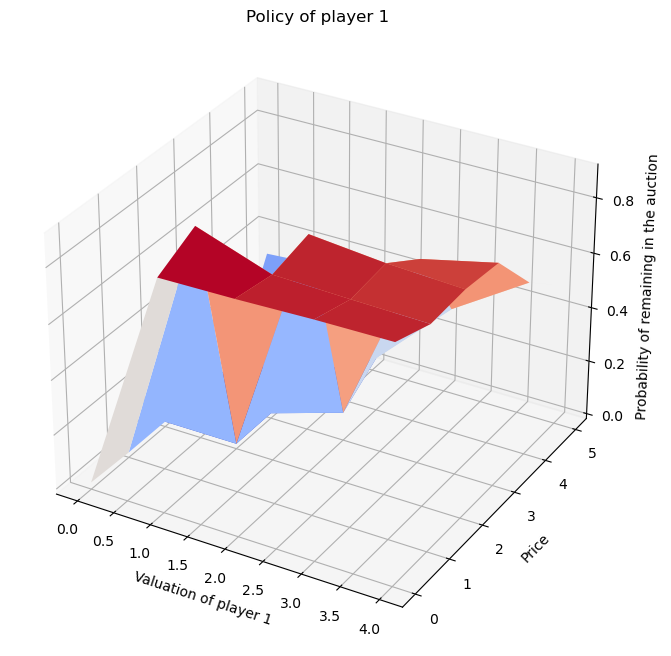

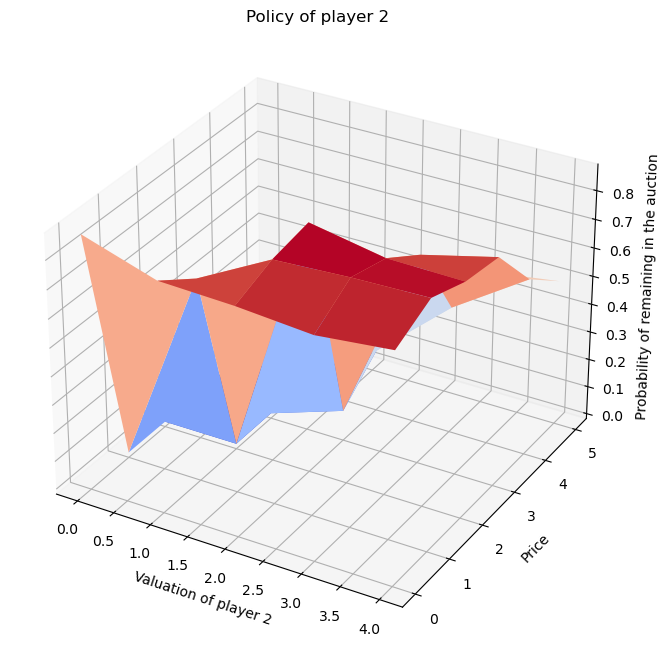

In [12]:
for player in range(number_of_players):
    three_dimensional_plot(player, policy_gradient.show_policy(player), max_valuation, price_increment)

The graphs above show that the agents learn to remain in the auction when their valuations are higher. In particular, this approximates the symmetric strictly increasing Nash equilibrium that we are using as the benchmark for this environment. 
Interestingly, the players deviate from each other when their valuation is zero. This may be because they are indifferent between winning and losing this auction as either way the agent would obtain a reward of zero, so while this is a deviation from the Nash equilibrium, this is not a profitable deviation.

Below we will consider the same algorithm in a larger environment. 

In [13]:
number_of_players = 4
max_valuation = 8
price_increment = 1
number_episodes = 3000
learning_rate = 0.001
credit_factor = 1
price_increment = 1

In [14]:
auction = RisingAuctionEnv(number_of_players, max_valuation, price_increment)
policy_gradient = PolicyGradientAlgorithm(auction, number_episodes, learning_rate, credit_factor)

In [15]:
policy_gradient.policy_gradient(100)

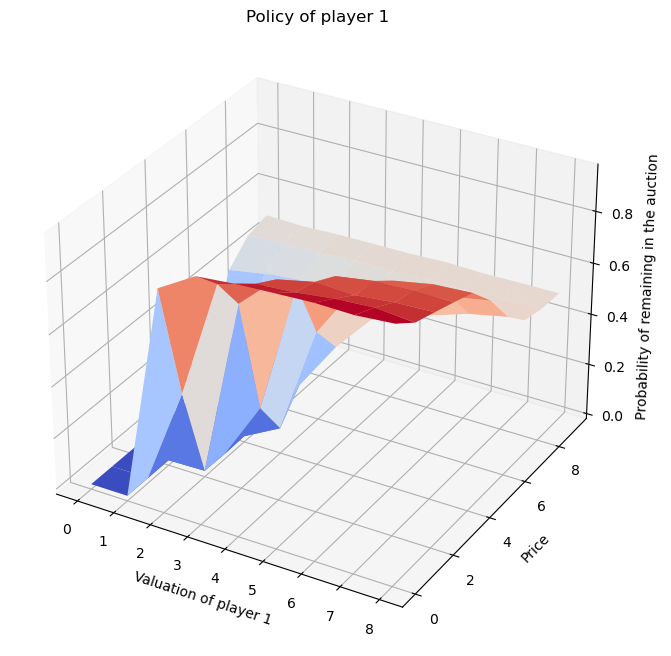

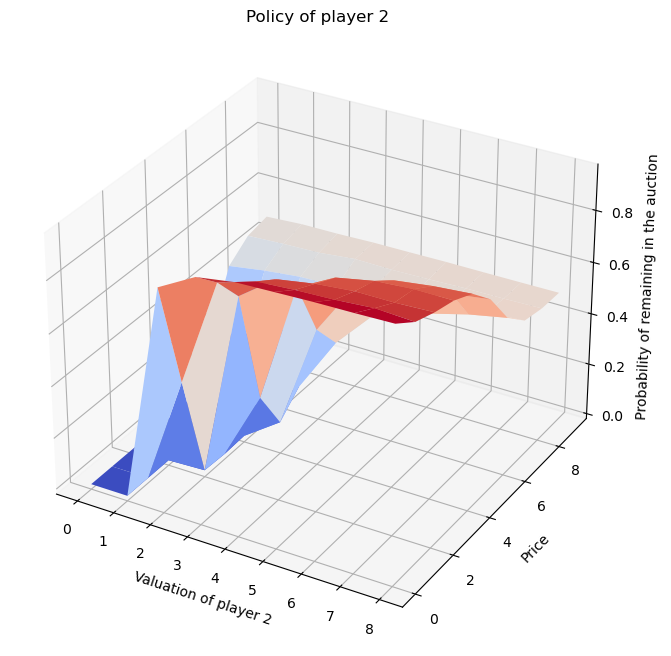

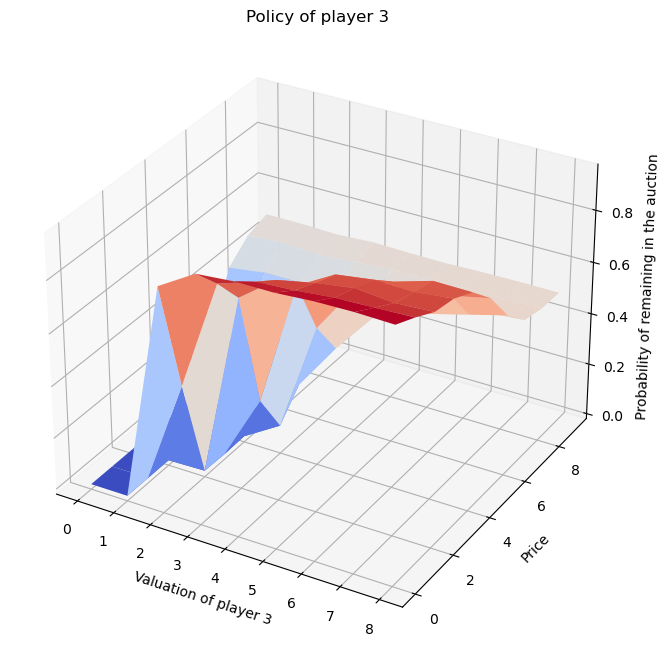

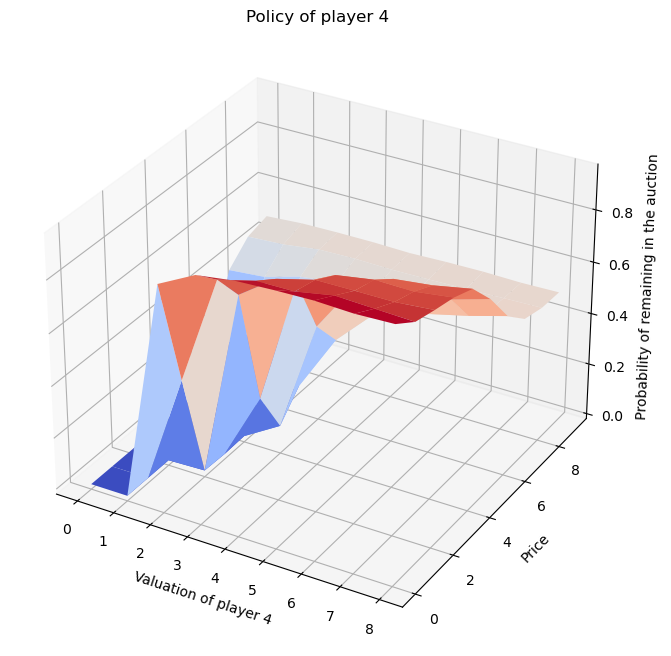

In [16]:
for player in range(number_of_players):
    three_dimensional_plot(player, policy_gradient.show_policy(player), max_valuation, price_increment)

In this larger example, we can see that we do have the approximately linear threshold strategy, however the relationship between the valuation and the threshold is not one to one, as would be expected. Futhermore, one can see that the policies for when the price is highest have not been learnt, even for when the valuation is low. This implies that there might be an exploration problem. 
This is because the auction has most likely terminated by the rounds when the price is highest. From further analysis, this problem is not resolved by lowering the learning rate, as the issue is to do with the ratio of times that the environment reaches the states with lower prices compared with higher prices. Further work could be done on using exploring starts to learn the policy in these rarely reached states. 

## Deep Policy Gradient Methods with Ascending Auctions

Using deep policy gradient methods for the ascending auction environments provides very good results, as the following two examples show:

In [17]:
number_of_players = 2
max_valuation = 4
price_increment = 1
auction = RisingAuctionDeepEnv(number_of_players, max_valuation, price_increment)

In [18]:
learning_rate = 0.0001
partial_state_size = 2
neural_network = NeuralNetwork(learning_rate, partial_state_size)

In [19]:
episodes_per_batch = 500
number_batches = 150
policy_gradient = DeepReinforceAlgorithm(auction, neural_network, episodes_per_batch, number_batches)
policy_gradient.reinforce()

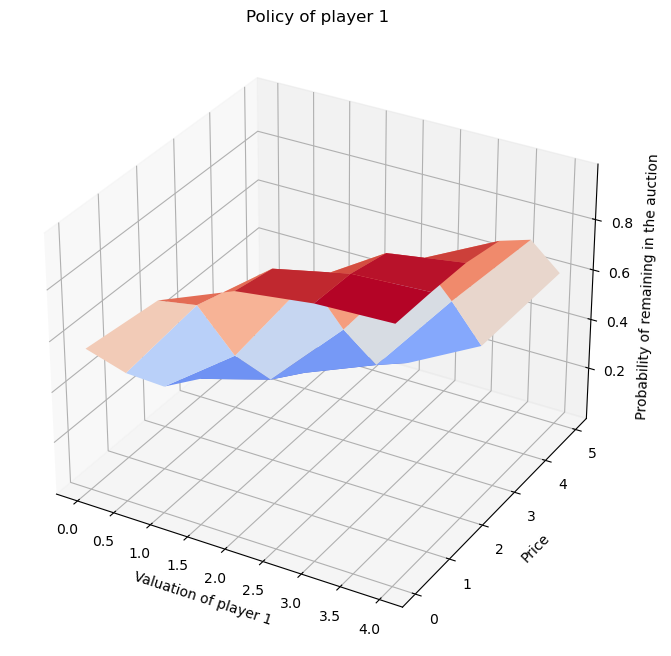

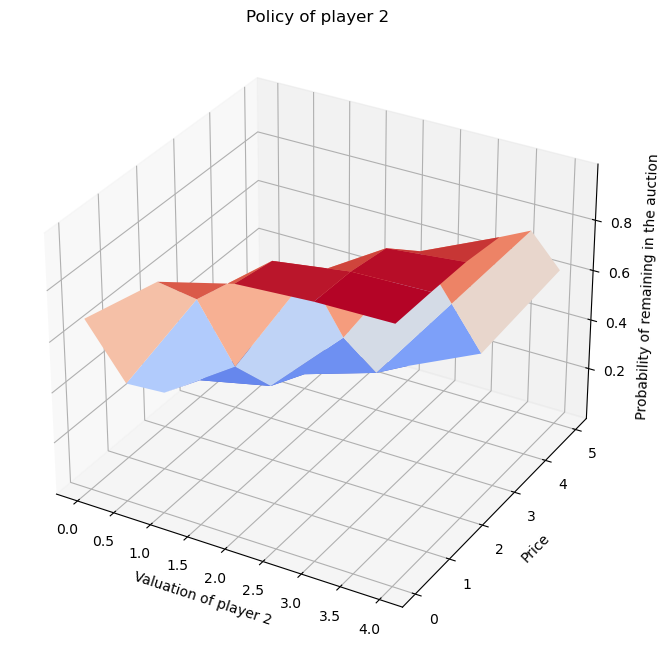

In [20]:
for player in range(number_of_players):
    three_dimensional_plot(player, policy_gradient.policy_table(player), max_valuation, price_increment)

In [21]:
number_of_players = 4
max_valuation = 8
price_increment = 1
auction = RisingAuctionDeepEnv(number_of_players, max_valuation, price_increment)

In [22]:
learning_rate = 0.0001
partial_state_size = 2
neural_network = NeuralNetwork(learning_rate, partial_state_size)

In [23]:
episodes_per_batch = 400
number_batches = 50
policy_gradient = DeepReinforceAlgorithm(auction, neural_network, episodes_per_batch, number_batches)

In [24]:
policy_gradient.reinforce()

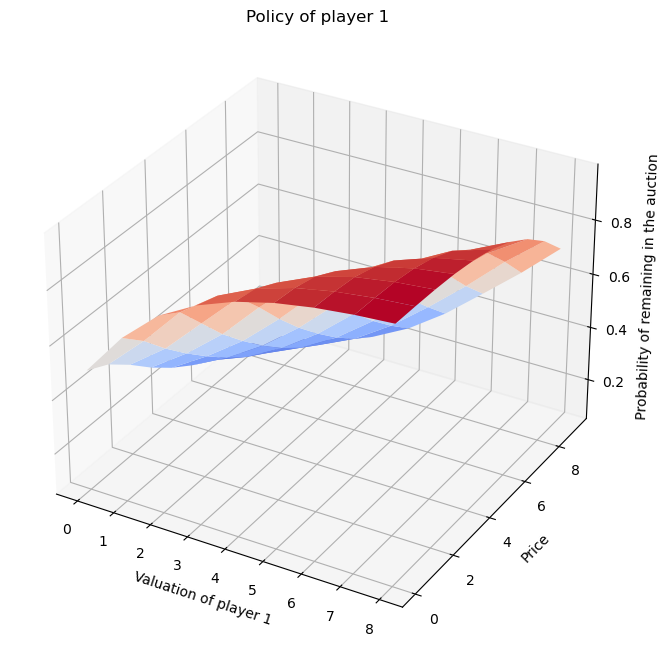

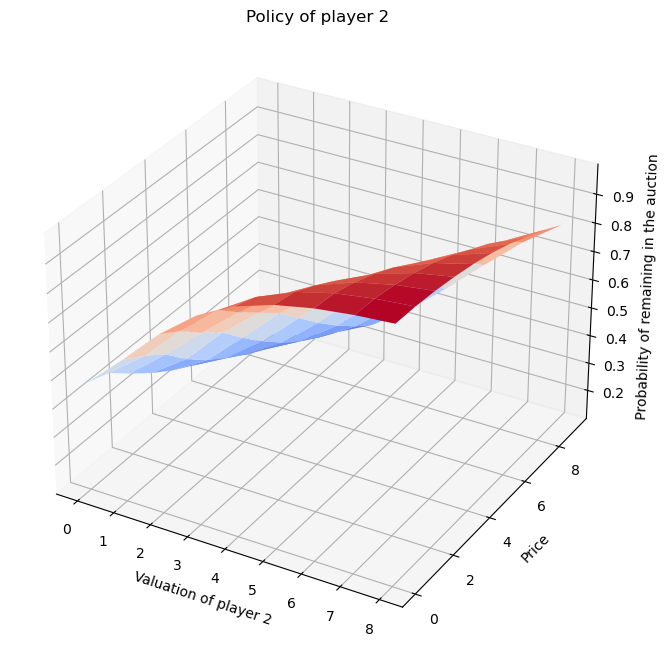

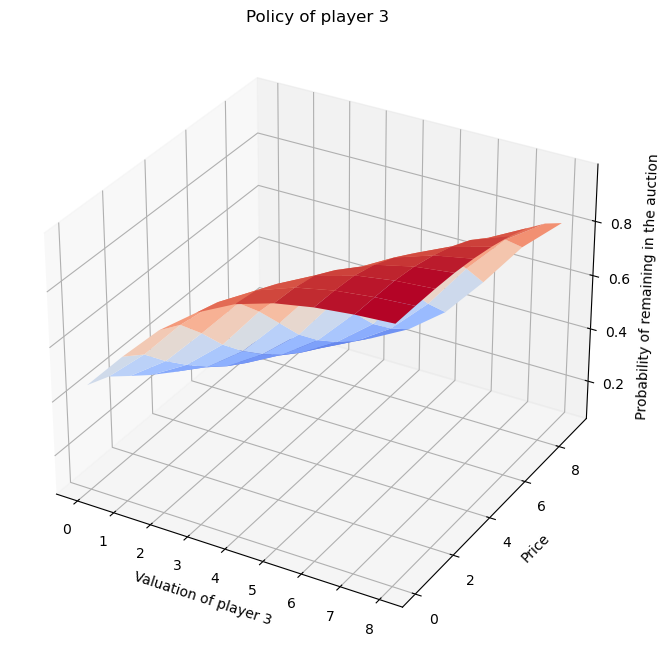

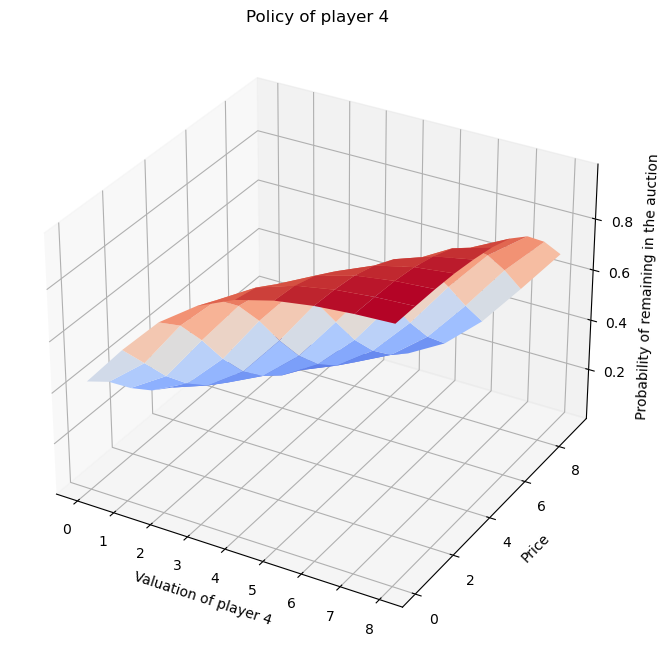

In [25]:
for player in range(number_of_players):
    three_dimensional_plot(player, policy_gradient.policy_table(player), max_valuation, price_increment)

In these examples, the agents are approximately playing the benchmark Nash equilibrium for this environment, and we do not have the problem of exploration that is seen in the non-deep policy gradient method. One might conjecture that this could be becuase the neural network is able to extrapolate from the states that are reached to the states that are not reached. This is a very interesting result that demonstrates the usefulness of deep learning in multiagent reinforcement learning.

## Policy Gradient Methods with Descending Auctions

We will now consider how policy gradient methods work in descending auctions.

In [26]:
number_of_players = 2
max_valuation = 4
price_increment = 1
number_episodes = 3000
learning_rate = 0.001
credit_factor = 1
price_increment = 1

In [27]:
auction = FallingAuctionEnv(number_of_players, max_valuation, price_increment)
policy_gradient = PolicyGradientAlgorithm(auction, number_episodes, learning_rate, credit_factor)
policy_gradient.policy_gradient(100)

/var/folders/qp/vv6_63sd0n954kctm_7hhrhh0000gn/T/ipykernel_79489/248559087.py:42: RuntimeWarning: overflow encountered in exp
  self.policies[player, price, valuation] += self.learning_rate * payoff * (1/(1+np.exp(parameter)))


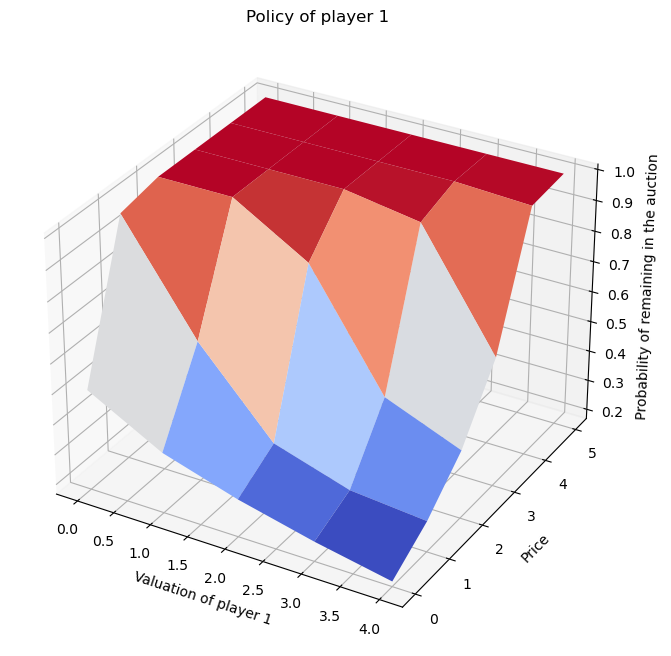

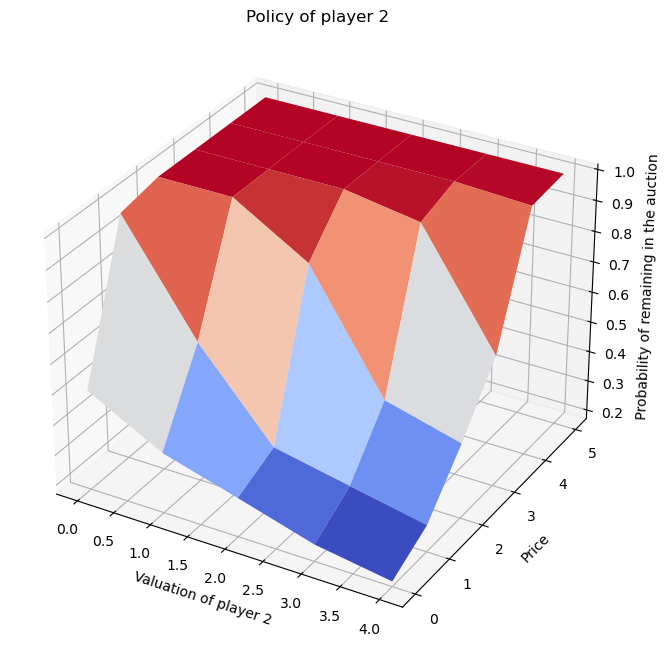

In [28]:
for player in range(number_of_players):
    three_dimensional_plot(player, policy_gradient.show_policy(player), max_valuation, price_increment)

In [43]:
number_of_players = 4
max_valuation = 8
price_increment = 1
number_episodes = 3000
learning_rate = 0.1
credit_factor = 1
price_increment = 1

In [44]:
auction = FallingAuctionEnv(number_of_players, max_valuation, price_increment)
policy_gradient = PolicyGradientAlgorithm(auction, number_episodes, learning_rate, credit_factor)
policy_gradient.policy_gradient(100)

/var/folders/qp/vv6_63sd0n954kctm_7hhrhh0000gn/T/ipykernel_79489/248559087.py:42: RuntimeWarning: overflow encountered in exp
  self.policies[player, price, valuation] += self.learning_rate * payoff * (1/(1+np.exp(parameter)))


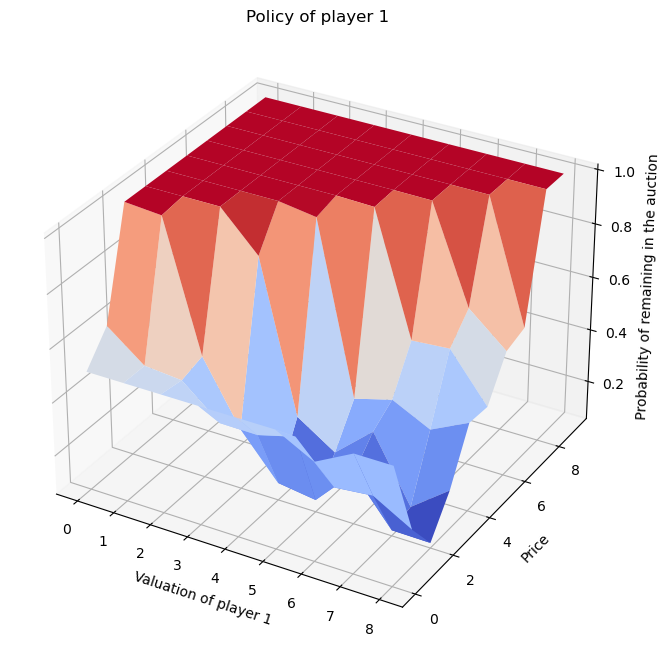

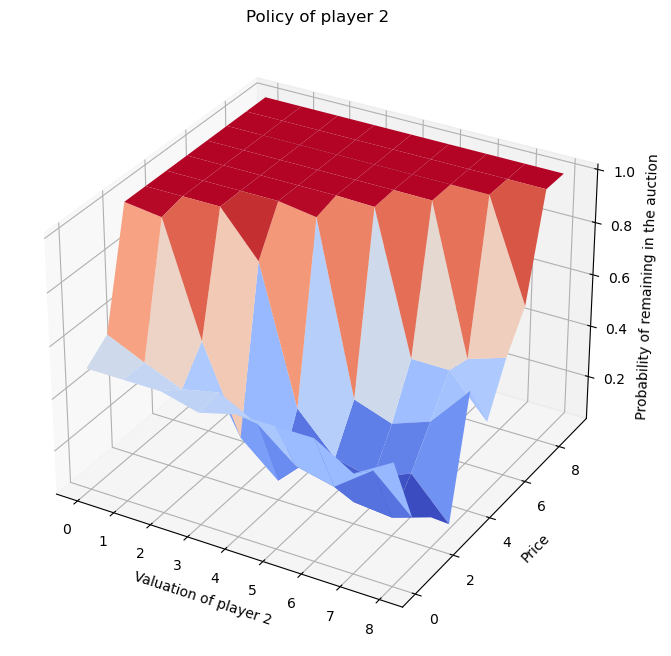

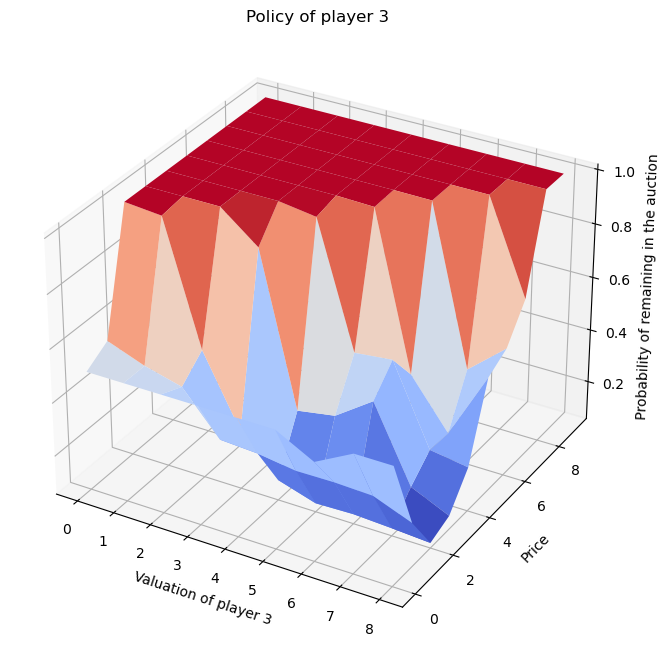

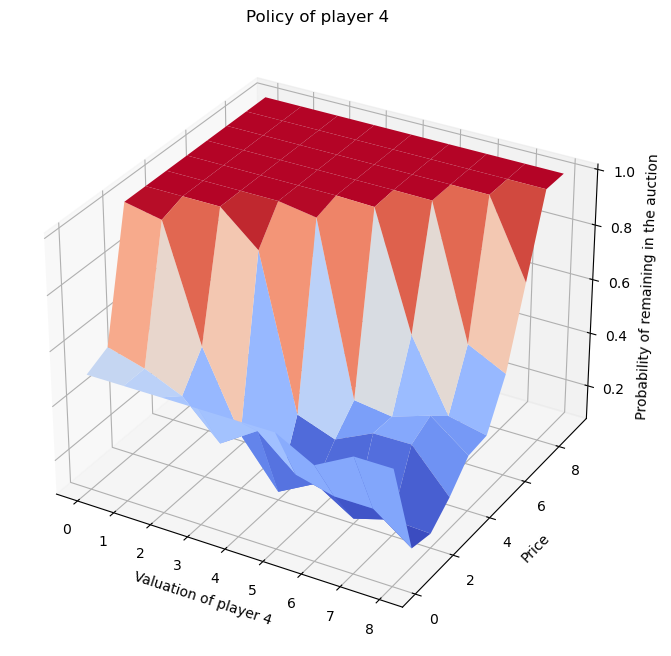

In [45]:
for player in range(number_of_players):
    three_dimensional_plot(player, policy_gradient.show_policy(player), max_valuation, price_increment)

In both examples, all the players learn to play nearly identical strategies. However, in the case of the descending auction with two players, the threshold between bidding and not bidding should be at half the valuations of the players, which is not seen here. The results from the four player game do correlate better with the equilibrium backmark, on the other hand.
While one can note that there is still an issue of exploration, as the price reaching zero rarely occurs, this is a smaller issue than in the ascending auctions, as this environment encourages longer rounds of play as this would reduce the prices for the agents.

## Deep Policy Gradient Methods with Descending Auctions

The following two examples show that, as in the ascending auction environments, the deep policy gradient method does significantly better than the non-deep policy gradient method when compared against the benchmark of the Nash equilibrium for this environment.

In [32]:
number_of_players = 2
max_valuation = 4
price_increment = 1
auction = FallingAuctionDeepEnv(number_of_players, max_valuation, price_increment)

In [33]:
learning_rate = 0.0001
partial_state_size = 2
neural_network = NeuralNetwork(learning_rate, partial_state_size)

In [34]:
episodes_per_batch = 400
number_batches = 100
policy_gradient = DeepReinforceAlgorithm(auction, neural_network, episodes_per_batch, number_batches)
policy_gradient.reinforce()

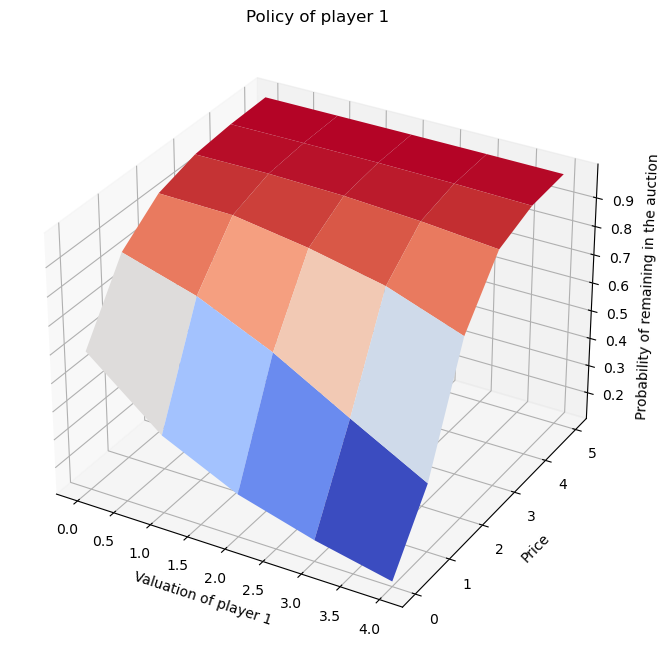

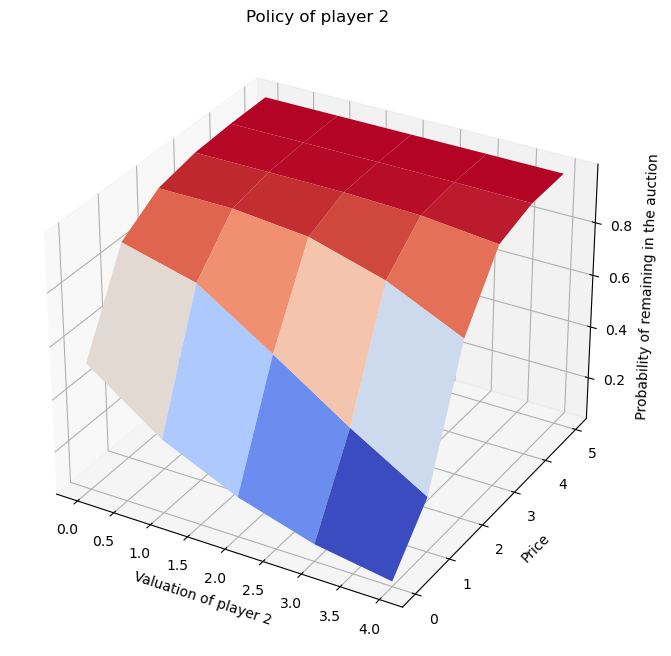

In [35]:
for player in range(number_of_players):
    three_dimensional_plot(player, policy_gradient.policy_table(player), max_valuation, price_increment)

Now let us look at a larger example:

In [36]:
number_of_players = 4
max_valuation = 8
price_increment = 1
auction = FallingAuctionDeepEnv(number_of_players, max_valuation, price_increment)

In [37]:
learning_rate = 0.001
partial_state_size = 2
neural_network = NeuralNetwork(learning_rate, partial_state_size)

In [38]:
episodes_per_batch = 500
number_batches = 20
policy_gradient = DeepReinforceAlgorithm(auction, neural_network, episodes_per_batch, number_batches)
policy_gradient.reinforce()

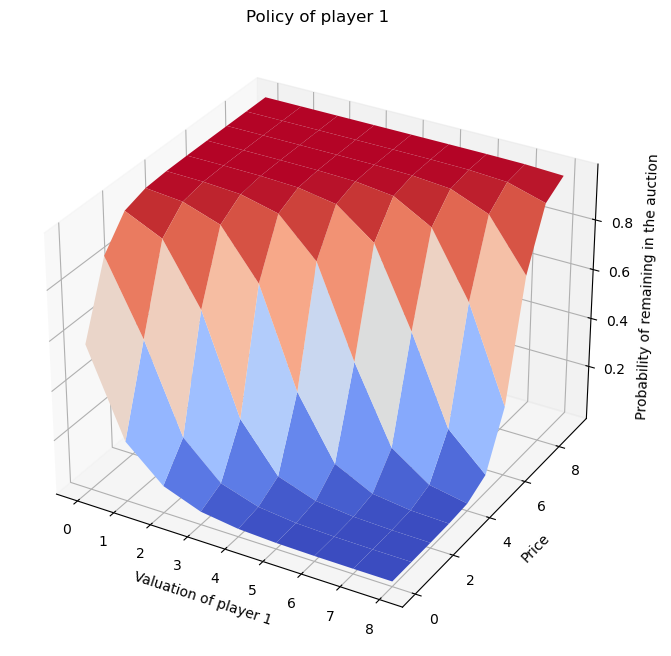

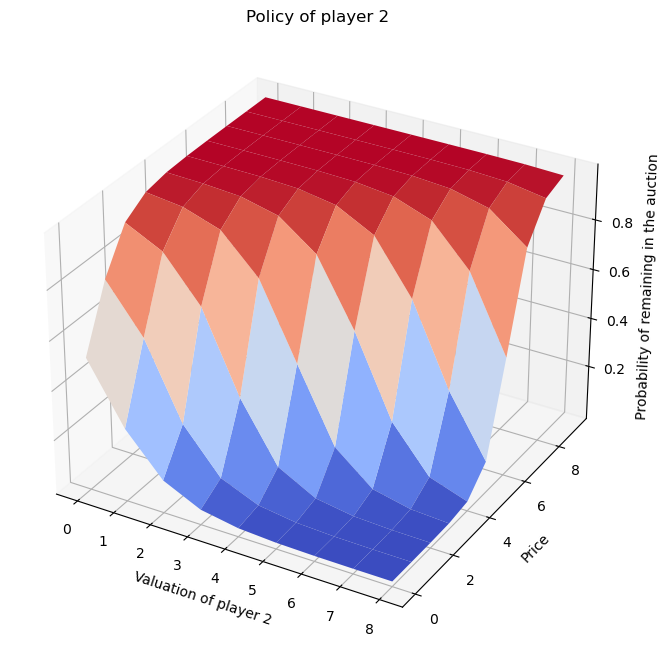

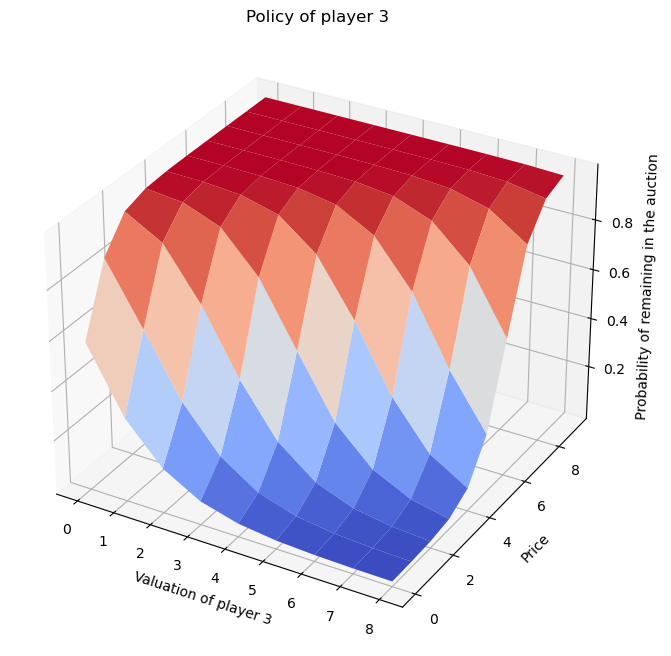

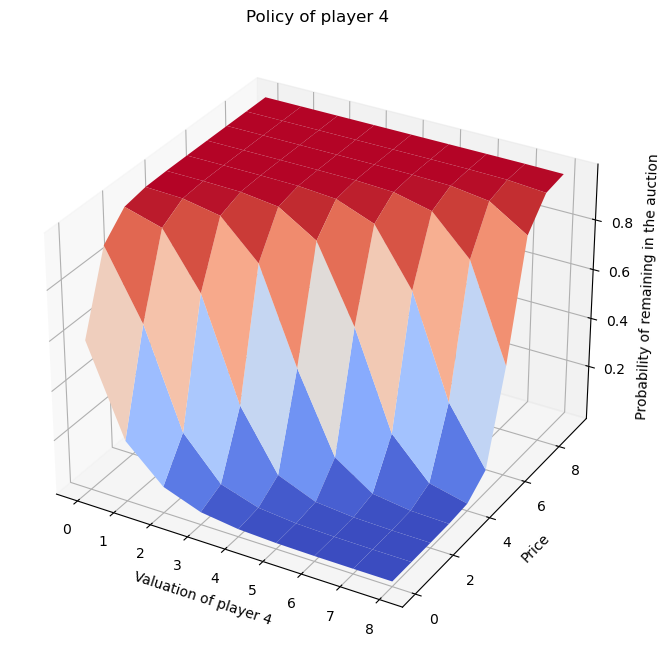

In [39]:
for player in range(number_of_players):
    three_dimensional_plot(player, policy_gradient.policy_table(player), max_valuation, price_increment)

From these graphs, one can observe that the agents learn to approximate the benchmark Nash equilibrium very well. 

### Conclusions from the policy gradient methods

This project has shown that policy gradient methods are able to converge to Nash equilibria in both ascending and descending auctions. In particular, deep policy gradient methods converge very well, which one might conjecture comes from their ability to extrapolate across states. Furthermore, one can conclude that descending auctions provide greater exploration of the states, as they incentivise the agents to remain within the auctions for further periods and so more states are visited. 

Further extensions of this work would consider larger environments with more players and higher maximum valuations. As well as this, the algorithms could be developed further, for example by adding exploring starts,  in order to encourage further exploration. One might note that the environments that we considered rarely provided negative rewards, hence one might want to consider if adding a buy-in into the auction might improve the learning in the auction. This is because it is well known that reinforcement learning algorithms perform better when the agent receives both positive and negative rewards. This would be interesting if this made a difference to the convergence performance, as, from a game theoretical perspective, a buy in would not change the strategic considerations, and so would not affect the Nash equilibria. 

## Q-Learning

Q-learning is a model-free reinforcement learning algorithm that aims to learn a policy that maximises the total reward. The algorithm learns an action-value function, which gives the expected utility (sum of rewards) of taking a certain action in a given state and following a fixed policy thereafter. The action-value function is usually denoted as Q, hence the name Q-learning.

It is considered model free as the update which is described in more detail below does not require information about the state transitions. 

The core of the Q-Learning algorithm is the Q-Learning update rule, which is a simple, yet powerful method to incrementally learn the value of actions. The Q-value for a state-action pair is updated by the equation:

Q-Learning Update Formula:

$$Q(s,a) \leftarrow Q(s,a) + \alpha \left(r + \gamma \max_{a'}Q(s',a') - Q(s,a) \right)$$

where:

- s and a are the current state and action.
- r is the reward observed after taking the action a in state s.
- s' is the new state after taking the action.
- a' is the action taken in the new state s'.
- α is the learning rate (0 ≤ α ≤ 1).
- γ is the discount factor (0 ≤ γ ≤ 1).

Q-Learning has the property of "off-policy" learning, meaning it learns the value of the optimal policy independently of the actions taken, by using the Bellman equation to update its Q-values.

Using the same notation as above, one can see that this simply iteratively solves the state-value bellman equation given below:

$$Q_\pi(s, a) = \sum_{s'}P_{ss'}^{a}(r(s, a) + \gamma\sum_{a'}\pi(a'|s')Q_\pi(s', a')$$


Deep Q-Learning, or DQN, extends the Q-Learning algorithm by using a neural network to approximate the Q-function. This approach is especially useful in problems with large state spaces where storing a table of Q-values is not feasible. In our case we use this approach to compare it to the classical Q-learning algorithm. 

### Implemenation of vanilla Q-learning algorithm

In [13]:
class QLearner:
    def __init__(self, n_agent, max_val, price_increment, environment, n_epsiodes, alpha = 0.01, gamma = 1, epsilon = 0.1, valuations = None):
        self.n_agents = n_agent
        self.max_val = max_val
        self.price_increment = price_increment
        self.actions = [0, 1]
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.rewards = [0] * self.n_agents #dont need I think
        self.withdraw = 0
        self.remain = 1
        self.env = environment
        self.n_episodes = n_epsiodes
        self.max_price = max_val + price_increment
        self.number_stages = int(self.max_price / self.price_increment) + 1
        self.num_actions = len(self.actions)
        if valuations is None:
            self.valuations = [list(range(self.max_val+1)) for _ in range(self.n_agents)]
        else:
            self.valuations = valuations
        self.q_tables = [np.zeros((len(self.valuations[0]), self.number_stages, 
            self.num_actions)) for _ in range(self.n_agents)]
   
    def reset(self):
        self.q_tables = [np.zeros((len(self.valuations[0]), self.number_stages, 
            self.num_actions)) for _ in range(self.n_agents)] # list for n_player Q_table shape (Valuation, current_price, action)
        self.rewards = [0] * self.n_agents
        self.env.reset()
        return self.q_tables

    def q_learning(self, q_value, next_q_value, reward):
        return q_value + self.alpha * ((reward + self.gamma * next_q_value) - q_value)

    def epsilon_greedy_policy(self, stage):
        actions = []
        for agent in range(self.n_agents):
            # valuation = valuations[player]
            valuation = self.env.valuations[agent]
            if np.random.binomial(1, self.epsilon) == 1:
                actions.append(np.random.randint(0, self.num_actions))
            else:
                # here updated to choose randomly when Q_values are equivalent
                array_of_interest = self.q_tables[agent][valuation, stage, :]
                opt_value = np.max(array_of_interest)
                max_indices = np.argwhere(array_of_interest == opt_value).flatten()
                actions.append(np.random.choice(max_indices))
        return actions
        
    def play(self): # edit to include a rewards list

        for player in range(self.n_agents):
            for valuation in range(self.max_val+1):
                for episode in range(self.n_episodes):
                    done = False
                    episode_memory = list()
                    current_price, valuations = self.env.reset()
                    if current_price == 0:
                        rising = True
                    else:
                        rising = False
                    self.env.valuations[player] = valuation
                    while not done:
                        
                        actions = self.epsilon_greedy_policy(current_price)  
                        episode_memory.append([current_price, actions[player]])
                        current_price, rewards, _, done = self.env.step(actions)
                        if actions[player] == self.env.withdraw:
                            done = True
                    for episode in episode_memory:
                        price, action = episode
                        q_value = self.q_tables[player][valuation, price, action]
                        if rising and price == self.max_price:
                            next_value = 0
                        elif rising:
                            next_value = self.q_tables[player][valuation, price+1, action]
                        elif not rising and price == 0:
                            next_value = 0
                        elif not rising:
                            next_value = self.q_tables[player][valuation, price-1, action]
                        self.q_tables[player][valuations[player], price, action] = self.q_learning(self.q_tables[player][valuations[player], price, action], next_value, rewards[player])
        return self.q_tables


In [14]:
# plotting Q-table function
def plot_policy(q_tables):

    """
    Function that plots the policy learned by the agents
    """

    for i in range(len(q_tables)):

        best_actions = np.argmax(q_tables[i], axis=2)

        # create a colour map for the actions
        cmap = mcolors.ListedColormap(["red", "blue"])

        # Visualise the Q-table using a heatmap
        fig, ax = plt.subplots(figsize=(8, 5))
        im = ax.imshow(best_actions, cmap=cmap, origin="lower")
        ax.set_title(f"Best Actions Player {i+1}")
        ax.set_xlabel("Price")
        ax.set_ylabel("Valuation")

        # set the ticks and tick labels
        ax.set_xticks(np.arange(q_tables[i].shape[1]))
        ax.set_yticks(np.arange(q_tables[i].shape[0]))

        # create a colour bar with custom tick labels
        cbar = fig.colorbar(im, ax=ax, ticks=[0, 1], boundaries=[-0.5, 0.5, 1.5], pad=0.02)
        cbar.ax.set_yticklabels(['Withdraw', 'Remain'])

        plt.tight_layout()
        plt.show()

## Q-Learning for Ascending Auctions

In [8]:
#hyperparameters for the Q-update and environment (small)
n_agents = 2
max_valuation = 4
price_increment = 1
n_episodes = 100_000
alpha = 0.01

env_rising = RisingAuctionEnv(n_agents, max_valuation, price_increment)

Q_agent = QLearner(n_agent=n_agents, max_val=max_valuation, price_increment=price_increment, environment=env_rising, n_epsiodes=n_episodes)

# initialise Q-tables
Q_agent.reset()

q_tables = Q_agent.play()

### Results for Ascending auction in small enironement (2 player, maximum valuation of 4)

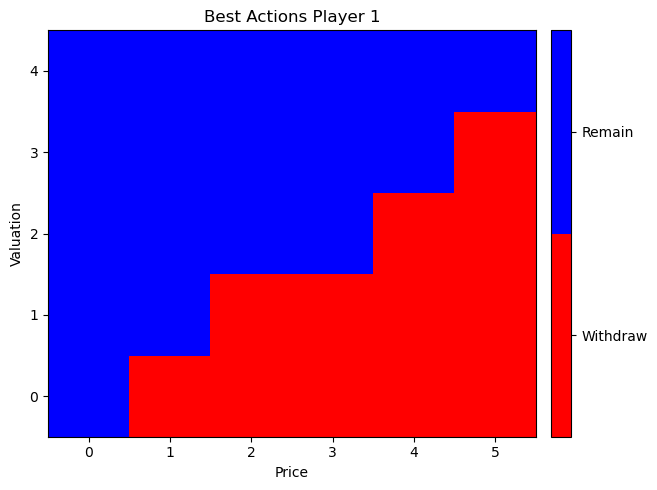

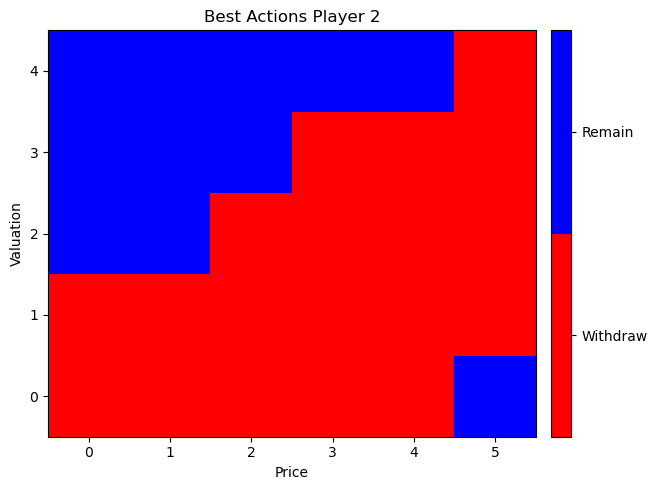

In [9]:
plot_policy(q_tables= q_tables)

In [15]:
# implementing the larger verions 
n_agents = 4
max_valuation = 8
price_increment = 1
n_episodes = 50_000
alpha = 0.01

env_rising2 = RisingAuctionEnv(n_agents, max_valuation, price_increment)

Q_agent = QLearner(n_agent=n_agents, max_val=max_valuation, price_increment=price_increment, environment=env_rising2, n_epsiodes=n_episodes)

# initialise Q-tables
Q_agent.reset()

q_tables2 = Q_agent.play()

### Results for Q-learning in larger ascending auction

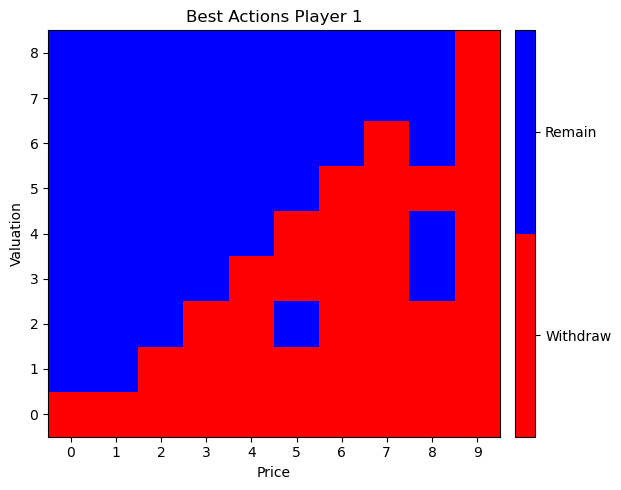

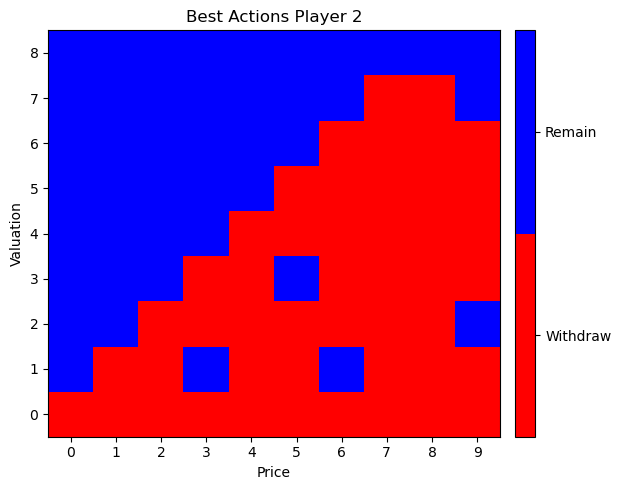

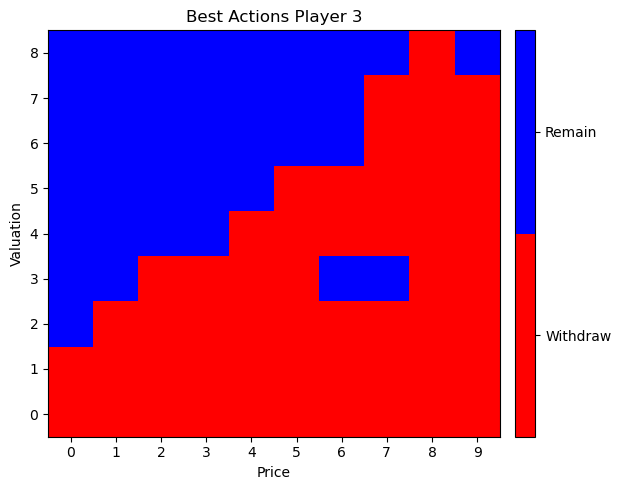

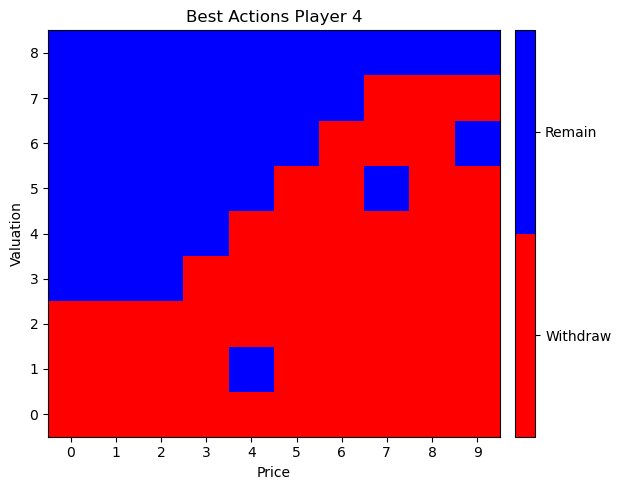

In [16]:
plot_policy(q_tables= q_tables2)

In the ascending auction, we observe that Q-learning agents begin to converge towards the expected Nash equilibrium, albeit with a few anomalies. In the smaller auction we would anticipate both agents to develop identical policies, yet after 100,000 episodes of individual training, they converge to distinct policies. One potential reason for this could be the lack of a decaying epsilon term, which may lead to overexploration and hinder the discovery of the optimal policy. We however, consider this unlikely given the constantly changing valuations of other agents in our environment. In fact, we believe that continuous exploration would be advantageous in multi-agent reinforcement learning. In the larger auction we observe a similar pattern. However, we begin to observe that most agents are converging at lower price levels. This would suggest, contrary to our previous claim, that there is underexploration of states where the price is higher. This is reasonable as there is a large penalty for remaining in the auction when prices rise above your valuation it thus incentivises agents with low valuation to withdraw early. This in turn causes the auction to end earlier rather than later such that the later states are visited less frequently. 

Another possibility is that Q-learning might be less suitable for this task. Since the environment is non-stationary – in other words, an agent's policy affects both the environment and the policies of other agents – it's conceivable that a stochastic policy could outperform a deterministic one. This is due to the greater flexibility of stochastic policies.


## Q-learning for descending auction

In [17]:
#reseting hyperparameters for small auction
n_agents = 2
max_valuation = 4
price_increment = 1
n_episodes = 50_000
alpha = 0.1
gamma = 1
epsilon = 0.2

env_falling_small = FallingAuctionEnv(n_agents=n_agents, max_valuation=max_valuation, price_increment=price_increment)
Qagent_falling = QLearner(n_agent = n_agents, max_val=max_valuation, price_increment=price_increment, environment=env_falling_small, n_epsiodes=n_episodes)

Qagent_falling.reset()
q_tables3 = Qagent_falling.play()

### Plotting Q-learning small auction result

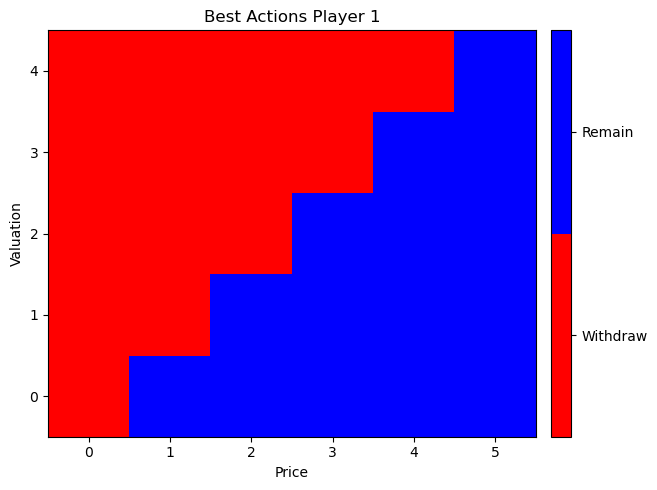

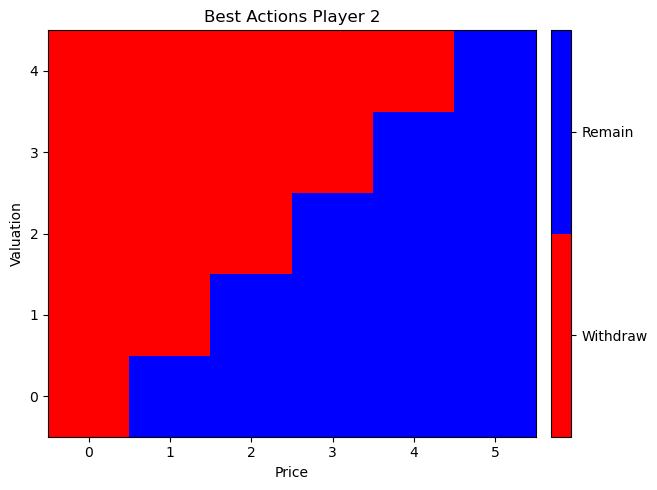

In [18]:
plot_policy(q_tables= q_tables3)

The descending auction environment seems to perform much better than the ascending aution. To some extent, this counters the last observation where overexploration could explain lacking performance in the ascending auction. Because the descending auction naturally incentivises exploration as payoffs are greater the longer the auction goes on, it is possible that more of the state space was explored. 

In [19]:
# larger auction 
n_agents = 4
max_valuation = 8
price_increment = 1
n_episodes = 50_000
alpha = 0.1
gamma = 1
epsilon = 0.2

env_falling_L = FallingAuctionEnv(n_agents=n_agents, max_valuation=max_valuation, price_increment=price_increment)
Qagent_falling = QLearner(n_agent = n_agents, max_val=max_valuation, price_increment=price_increment, environment=env_falling_L, n_epsiodes=n_episodes)

Qagent_falling.reset()
q_tables4 = Qagent_falling.play()

### Plotting Q-learning large auction results

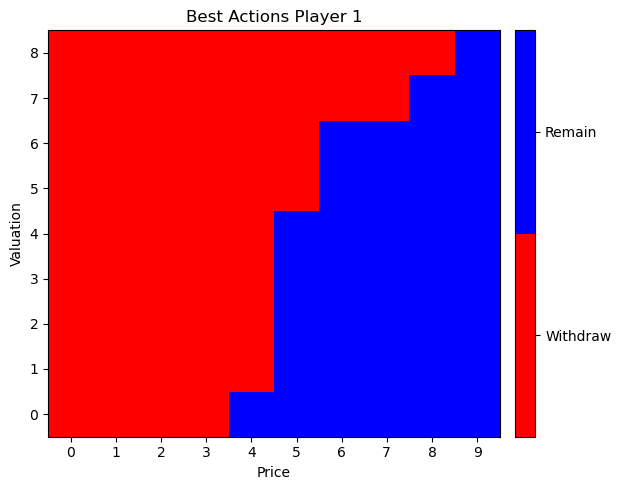

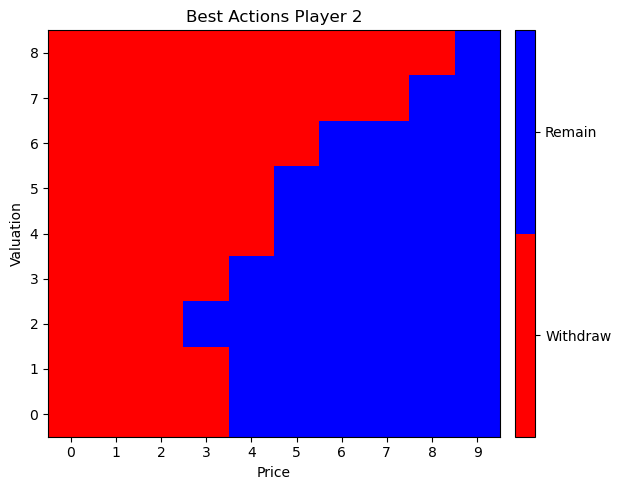

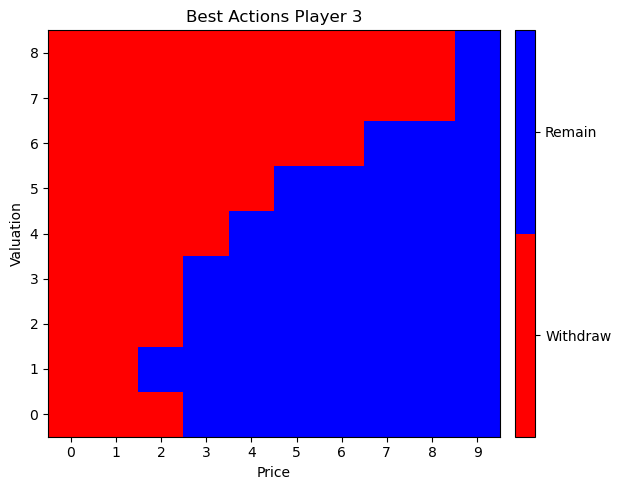

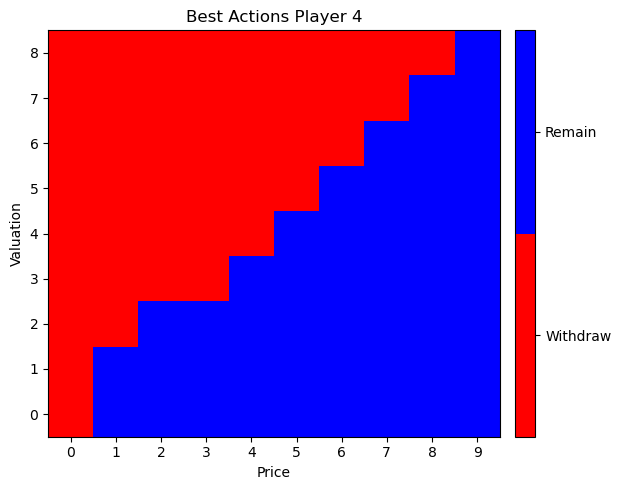

In [20]:
plot_policy(q_tables= q_tables4)

In the larger example it seems the equilibirum was not reached, this could is somewhat expected as we expect when there are more agents the environment is more afffected by the valuations and policies of other agents. It also seems that some players were able to converge better than others. Player 4 for example is very close to the Nash policy. There seems to be a trend again that exploration in the later stages is weaker, as the policy at higher pices seems to resemble the optimal policy slightly better. 

## Q-learning Conclusion

Our Q-learning agents seem to begin to converge toward the Nash equilibrium policies, although we do observe that the policy gradient methods outperform the Q-learning agents in both environments. We also observe that the Q-learning methods perform better in the descending auction than the ascending auctions. This is likely due to the increased incentives to explore later stages of auctions in the descending environment while this is likely to be penalised in the ascending auction. 

Q-learning seems to be less suited for these environments because of the nature of the deterministic policy which doesn't allow for continued epxloration and could lead to bias. Especially if an inaccurate Q-value is learned at early stages, it could lead to the data collection in later stages to underexplore potentially more optimal strategies. 

## Overall Conclusion

Overall, we find that policy gradient methods seem to converge to Nash equilibria more consistantly in all settings compared with the Q-learning method. Our hypothesis is that this is due to the nature of the stochastic policy learned by policy gradient algorithms compared to the determistic policy in Q-learning. The stochastic policy provides greater flexibility in the updates, while also allowing for a more continuous exploration during the learning stages. Furthermore, we find that Dutch auctions seem to allow for faster convergence to Nash equilibria than English auctions for both reinforcement learning paradigms. We attribute this to the larger incentives for exploring later stages of the auction when compared to the English auction.  

Further research can be conducted to look into larger environment with more players and larger maximum valuations to see if our findings remain consistent. Our prediction is that the convergence should remain roughly the same as we have observed given that our larger environment sometimes performed even better than the smaller environments. This was especially true for the policy gradient agents and for ascending auction environments. We explain this observation by noting that having more players in the ascending auction increases the probabiity of reaching the later stages of the auction, and hence exploration would be further improved. One would note that the opposite is true for the descending auctions, and so it would be very interesting to investigate if our finding remain consistent for larger descending auctions. Another area of exploration could be to analyse the effect of reward shaping, as including both positive and negative has been shown to improve the performance of reinforcement learning agents, whereas, in our environments only a few rewards will be negative, especially for agents with high valuations. This would be very interesting to investigate, as it is in contrast with the game theory literature, because Nash equilibria are invariant under linear transformations of payoffs. 

### Bibliography

Klemperer, P. (2004). Auctions: Theory and Practice. Princeton University Press. http://www.jstor.org/stable/j.ctv3hh4pm

Kanmaz, M. and Surer, E. (2017) Using Multi-Agent Reinforcement Learning in Auction Simulations arXiv:2004.02764

Littman, L. (1994) Markov games as a framework for multi-agent reinforcement learning. Proceedings of the Eleventh International Conference on Machine Learning (pp. 157-163)

Hu, J. and Wellman, M. P. (2003) Nash Q-Learning for General-Sum Stochastic Games. JMLR.org. Volume 4. Pages 1039–1069.

Shoham, Y., Powers, R. and Grenager, T. (2007) If multi-agent learning is the answer, what is the question? Artificial Intelligence, Volume 171, Issue 7, Pages 365-377.

Leonardos, S., Overman, W., Panageas, I. and Piliouras, G. (2021) Global Convergence of Multi-Agent Policy Gradient in Markov Potential Games. arXiv:2106.01969

Daskalakis, C., Foster, D.J. and Golowich, N. (2021) Independent Policy Gradient Methods for Competitive Reinforcement Learning. arXiv:2101.04233

Giannou, A., Lotidis, K., Mertikopoulos, P. and Vlatakis-Gkaragkounis, E. V. (2022) On the convergence of policy gradient methods to Nash equilibria in general stochastic games. arXiv:2210.08857

### Appendix

#### Nash Equilibrium

Formally, let us define a stochastic game. As before, the set of players is $N = \{1,...,n\}$. Player $i$'s finite set of actions is $A_{i}$, and the mixed action set of $i$ is $\Delta A_{i}$. The set of pure action profiles is $A = \prod_{i = 1}^{n} A_{i}$. We will have a set of states $S$ and a transition function $P$ such that $P(s' | s, a)$ denotes the probability of transitioning from state $s$ to state $s'$ when $a \in A$ is the action profile of the agents. For each $i \in N$, the reward function of player $i$ is $R_{i} : A \times S \rightarrow \mathbb{R}$. We will let some $s \in S$ be the terminal state, which means that once this state is reached it is never left and all rewards in this state are zero. Furthermore, let $\rho \in \Delta(S)$ be the initial distribution over states. Denote this game by $G = (N, S, A, R, \rho)$ where $R = (R_i)_{i = 1}^{n}$.

The stage game G is played at each $t \in \mathbb{N}$. Let $(s^{(t)},a^{(t)}) \in S \times A$ be the realised state-action profile pair in round $t$, and let $h^{t} = ((s^{(1)},a^{(1)}), ..., (s^{(t)},a^{(t)})) \in (S \times A)^{t}$ be the history of play at the end of round $t$. Furthermore, $(S \times A)^{0}$ is the empty history and $H^{\infty} = \cup_{t=0}^{\infty} (S \times A)^{t}$ is the set of all histories.

We consider an episodic setting, where in each episode a realisation of the stochastic game is played. An outcome of an episode is thus given by $h^{\infty} = (s^{(t)},a^{(t)})_{t = 1}^{\infty}$. Therefore, player $i$'s average discounted payoff is defined as:
$$U_{i}(h^{\infty}) =  \sum_{t = 1}^{\infty} R_{i}(s^{(t)},a^{(t)}) $$

We will assume that the history reaches the terminal state with probability one to ensure that this is well defined. 

For each agent $i \in N$, a policy is $\pi_{i} : H^{\infty} \rightarrow \Delta(A_{i})$. 
Let $\pi = (\pi_{i})_{i = 1}^{n} \in \Pi$ where $\Pi = \prod_{i = 1}^{n} \Pi_{i}$. 

The expected reward of agent $i \in N$ if the agents' policy is $\pi$ can therefore be given by:
$$V_{i}(\pi) = \mathbb{E}_{\pi} \left [ \sum_{t = 1}^{\infty} R_{i}(s^{(t)},a^{(t)}) \right ] $$

Therefore, a policy profile $\pi^{*} \in \Pi$ is a Nash equilibrium if $\forall i \in N$ and $\forall \pi_{i}$, $V_{i}(\pi^{*}) \geq V_{i}(\pi_{i}, \pi_{-i}^{*}) $

For auctions, one should note that it is without loss of generality to restrict attention to threshold strategies, which are strategies which specify a price that an agent is willing to bid for the object if and only if the price is less than this threshold. Therefore, it will be the agent whose threshold is highest that will win the auction. This observation is key, as it demonstrates that these dynamic auctions are strategically equivalent to sealed-bid auctions, which are auctions where the agents just write down one number (their bid) and then the item goes to whichever agent bid the highest number.

One can futher observe that the English auction is strategically equivalent to the sealed bid second-price auction, which is an auction where which agent that bid the highest wins the item, but at the second highest price. This is because the price in an English auction only rises as high as the second-highest threshold. Futhermore, the Dutch auction is strategically equivalent to the sealed bid first-price auction, which is an auction where which agent that bid the highest wins the item and they pay the highest price.

Sealed bid auctions are static games, in which each player symmutaneously chooses one action. Suppose that, for each player $i \in N$, actions are determined by some $\pi_{i} : [0, \bar{v}] \rightarrow [0, \bar{v}]$ where $\bar{v}$ is the maximum valuation and $\pi_{i}$ is strictly increasing and differentiable. We will also assume that valuations are drawn independently from some continuous distribution $F$ on $[0, \bar{v}]$.

Then, for the first price sealed bid auction, player $i$ with valuation $v_{i}$ and bid $a_{i}$ will have expected payoff:

$$ \int_{0}^{\pi^{-1}(a_i)} ... \int_{0}^{\pi^{-1}(a_i)} (v_i - a_i)dF(v_{-i}) = (v_{i} - a_{i})F(\pi^{-1}(a_{i}))^{n-1} $$

where we have used that $\pi_{j}$ is strictly increasing $\forall j$. We then can take first-order conditions to obtain that $a_{i}$ must solve:

$$-F(\pi^{-1}(a_{i}))^{n-1} + (n-1) F(\pi^{-1}(a_{i}))^{n-2} \frac{F'(\pi^{-1}(a_{i}))}{\pi'(\pi^{-1}(a_{i}))}(v_{i} - a_{i}) = 0 $$

To have a symmetric equilibrium, one must have that $\pi(v_{i}) = a_{i}$. Therefore:

$$ F(v_i)^{n-1}\pi'(v_{i}) + (n-1)F(v_i)^{n-2}F'(v_i)\pi(v_i) = (n-1)F(v_i)^{n-2}F'(v_i)v_i$$

Then, one can note that:

$$F(v_i)^{n-1}\pi(v_{i}) = \int^{v_i}_{0}(F(x)^{n-1})'x dx$$

Thus, one concludes that the symmetric, strictly increasing and differentiable Nash equilibrium is

$$\pi(v_{i}) = \frac{\int^{v_i}_{0}(F(x)^{n-1})'x dx}{F(v_i)^{n-1}} = v_{i} - \frac{\int^{v_i}_{0}F(x)^{n-1} dx}{F(v_i)^{n-1}}$$

In particular, if the valuations are uniformly distributed on $[0, \bar{v}]$, one obtains that $\pi(v_i) = \frac{n-1}{n} v_i$

For the second price sealed bid auction, player $i$ with valuation $v_{i}$ and bid $a_{i}$ will have expected payoff:

$$ \mathbb{P}(a_i \geq \pi(v_j) \forall j \neq i) \mathbb{E}[v_i - \max_{j \neq i}\pi(v_j)| a_i \geq \pi(v_j) \forall j \neq i] = F(\pi^{-1}(a_i))^{n-1}v_i - \int^{a_i}_{0} (F(\pi^{-1}(y))^{n-1})'y dy $$

We then can take first-order conditions to obtain that $a_{i}$ must solve:

$$(F(\pi^{-1}(a_i))^{n-1})'v_i - (F(\pi^{-1}(a_i))^{n-1})'a_i = 0$$

Hence, one obtains that $\pi(v_i) = v_i$. Note that this is not dependent upon valuations being uniformly distributed. 

Therefore, we conclude that the policy profile where players continue to bid until they reach their valuation is a Nash equilibrium in the ascending auction, and the policy profile where players withdraw from the auction when the price is equal to $\frac{n-1}{n}$ of their valuation is a Nash equilibrium in the descending auction.